<a href="https://colab.research.google.com/github/lamtung1997/Solving_PDEs_Deep_learning/blob/main/4_Heat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SETUP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import math
import itertools
import os
import logging
from numpy import loadtxt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import cv2
import glob
import imageio

# number pi
pi = math.pi

# STOP WARNING
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# random_seed
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# DATA

dt = 0.2                    # time-step
T = 3                       # T
nots = int(T/dt) + 1        # number of time steps
n = 20                      # number of points in a border
c = np.linspace(0, 1, n)    # coordinates from 0 to 1 with uniform distribution
P_in, P_border = [], []
for i, j, k in itertools.product(range(n), range(n), range(nots)):
    p = [c[i], c[j], k*dt]
    if(i == 0 or i == n-1 or j == 0 or j == n-1):
        P_border.append(p)
    else:
        P_in.append(p)

# upsampling P_border that its size is equal to P_in
for i in range(len(P_in)-len(P_border)):
    j = i%(len(P_border))
    P_border.append(P_border[j])

# convert numpy array, P_in and P_border to Tensorflow Dataset
P_in = tf.convert_to_tensor(P_in, dtype=tf.float32)
P_border = tf.convert_to_tensor(P_border, dtype=tf.float32)

batch_size = 1
bs = int(len(P_in))

P_in = tf.data.Dataset.from_tensor_slices((P_in))
P_in = P_in.shuffle(buffer_size=bs).batch(batch_size)

P_border = tf.data.Dataset.from_tensor_slices((P_border))
P_border = P_border.shuffle(buffer_size=bs).batch(batch_size)

print("Number of datas: ", int(P_in.cardinality()*batch_size*2))

Number of datas:  10368


In [3]:
# MODEL
nn = 16
inputs = keras.Input(shape=(3,), name='points')
hidden_1 = layers.Dense(nn, activation='tanh', name='hidden_1')(inputs)
hidden_2 = layers.Dense(nn, activation='tanh', name='hidden_2')(hidden_1)
hidden_3 = layers.Dense(nn, activation='tanh', name='hidden_3')(hidden_2)
outputs = layers.Dense(1, activation='linear', name="u")(hidden_3)
model = keras.Model(inputs=inputs, outputs=outputs, name='heat_continuous')
model.summary()

Model: "heat_continuous"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
points (InputLayer)          [(None, 3)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 16)                64        
_________________________________________________________________
hidden_2 (Dense)             (None, 16)                272       
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                272       
_________________________________________________________________
u (Dense)                    (None, 1)                 17        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [4]:
# CHOOSE OPTIMIZER
optimizer = tf.keras.optimizers.Adam()

In [5]:
# TRAIN FUNCTION
@tf.function
def train_step(P_in, P_border):
    with tf.GradientTape(persistent=True) as tape:
        loss_in, loss_border = [0], [0]
        # interior loss
        for i in range(P_in.shape[0]):
            z = tf.reshape(P_in[i], shape=(1,3))
            tape.watch(z)
            u = model(z)

            # calculating u_
            u_x = tape.gradient(u, z)[0][0]
            u_xx = tape.gradient(u_x, z)[0][0]

            u_y = tape.gradient(u, z)[0][1]
            u_yy = tape.gradient(u_y, z)[0][1]

            u_t = tape.gradient(u, z)[0][2]

            # calculating f(x,y)
            f = (1 + 2*pi*pi)* tf.math.exp(z[0][2]) * tf.math.sin(pi*z[0][0]) * tf.math.sin(pi*z[0][1])

            # calculating loss_in
            loss_in += tf.math.square(u_t - (u_xx + u_yy) - f)

        # boundary loss
        for j in range(P_border.shape[0]):
            z = tf.reshape(P_border[j], shape=(1,3))
            tape.watch(z)
            u = model(z)

            loss_border += tf.math.square(u)
        
        # loss function
        batch_loss = loss_in + loss_border
    
    # update weights
    grads = tape.gradient(batch_loss, model.trainable_weights)          # gradient of loss function with respect to w
    optimizer.apply_gradients(zip(grads, model.trainable_weights))      # update w

    return batch_loss

In [6]:
# TRAIN FUNCTION
losses = []
def train(learning_rate):
    optimizer.learning_rate.assign(learning_rate)
    loss = 0
    for (P_in_batch,P_border_batch) in itertools.zip_longest(P_in,P_border):
        batch_loss = train_step(P_in_batch, P_border_batch)
        loss += batch_loss
    losses.append(loss.numpy())

In [7]:
# TRAIN
i = 0
max_ite = 1000
lr = 1e-3
start = time.time()
print("Learning rate:", lr)
while(True):
    start_ite = time.time()
    train(lr)
    if(i%10 == 0):
        print("[%3s] loss = %13.7f \t %5.3fs \t less than %5.3f minutes to finish" % (i, losses[i], time.time() - start_ite, (time.time() - start_ite)*(max_ite - i)/60))
    if(i > 200):
        if(losses[i] > np.min(losses[1-200: i - 100])):
            lr = lr/10
            if(lr < 1e-6):
                break
            print("\nNew learning rate:", lr)
    if(i > max_ite):
        break
    i = i + 1


print("Total time: %.2f minutes" % ((time.time() - start)/60))

Learning rate: 0.001
[  0] loss = 17975294.0000000 	 6.906s 	 less than 115.096 minutes to finish
[ 10] loss = 406957.7812500 	 5.825s 	 less than 96.108 minutes to finish
[ 20] loss = 344241.4375000 	 5.573s 	 less than 91.024 minutes to finish
[ 30] loss = 229674.3281250 	 6.085s 	 less than 98.369 minutes to finish
[ 40] loss = 230973.2500000 	 6.399s 	 less than 102.383 minutes to finish
[ 50] loss = 209092.6406250 	 5.737s 	 less than 90.840 minutes to finish
[ 60] loss = 158829.6718750 	 5.687s 	 less than 89.103 minutes to finish
[ 70] loss = 165267.5312500 	 5.717s 	 less than 88.612 minutes to finish
[ 80] loss = 138569.7812500 	 5.599s 	 less than 85.844 minutes to finish
[ 90] loss = 143114.0312500 	 5.744s 	 less than 87.113 minutes to finish
[100] loss = 135176.8750000 	 5.664s 	 less than 84.959 minutes to finish
[110] loss = 127781.6562500 	 5.652s 	 less than 83.842 minutes to finish
[120] loss = 114817.0312500 	 5.597s 	 less than 82.094 minutes to finish
[130] loss = 

In [8]:
model.save("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/u.h5")

In [9]:
model1 = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/u.h5")

In [10]:
def u(network,x,y,t):
    z = tf.convert_to_tensor([[x, y, t]])
    u = float(network(z))
    return u

dt = 0.2                    # time-step
T = 3                       # T
nots = int(T/dt) + 1        # number of time steps
n = 31                      # number of points in a border
c = np.linspace(0, 1, n)    # coordinates from 0 to 1 with uniform distribution
P = []
for i, j, k in itertools.product(range(n), range(n), range(nots)):
    p = [c[i], c[j], k*dt]
    P.append(p)

def exact_sol(x,y,t):
    return math.exp(t)*math.sin(pi*x)*math.sin(pi*y)

err = 0
for i in range(len(P)):
    err += (u(model1, P[i][0], P[i][1], P[i][2]) - exact_sol(P[i][0], P[i][1], P[i][2]))**2

L2 = math.sqrt(err/len(P))
print("L2 = ", L2)

L2 =  0.2489945575064896


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


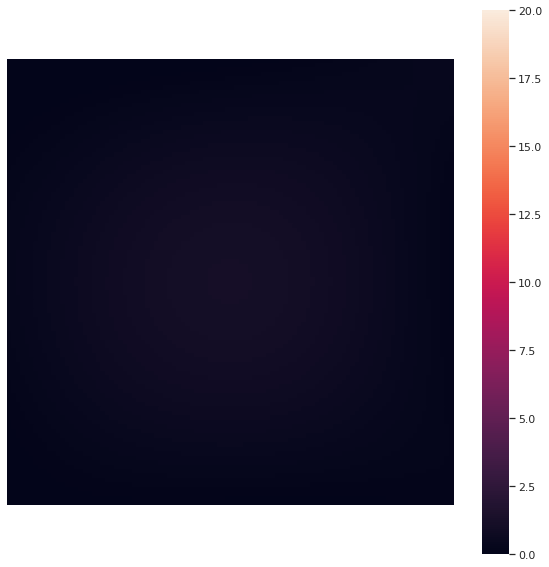

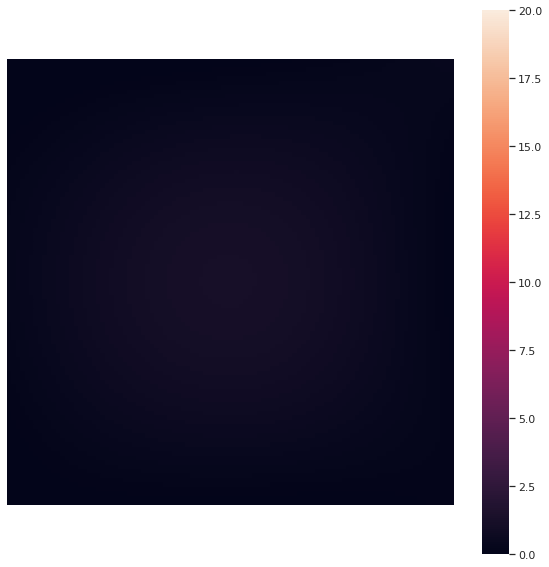

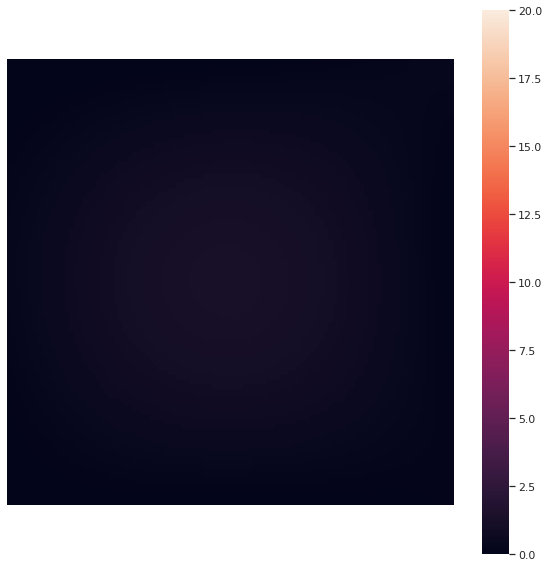

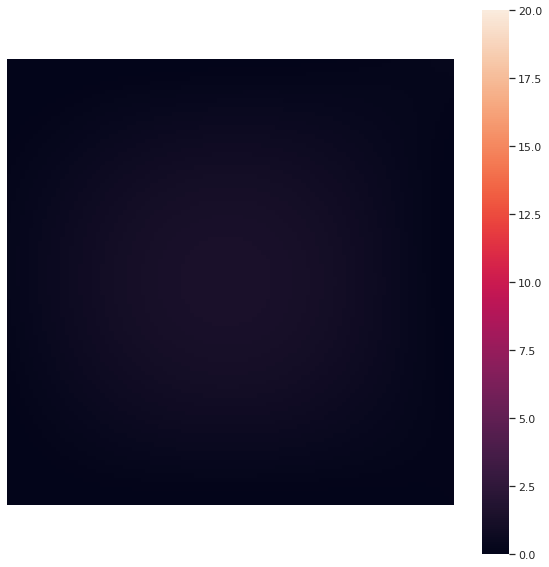

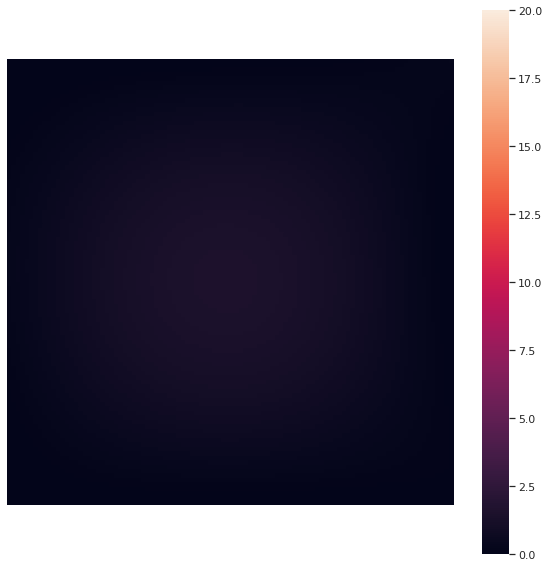

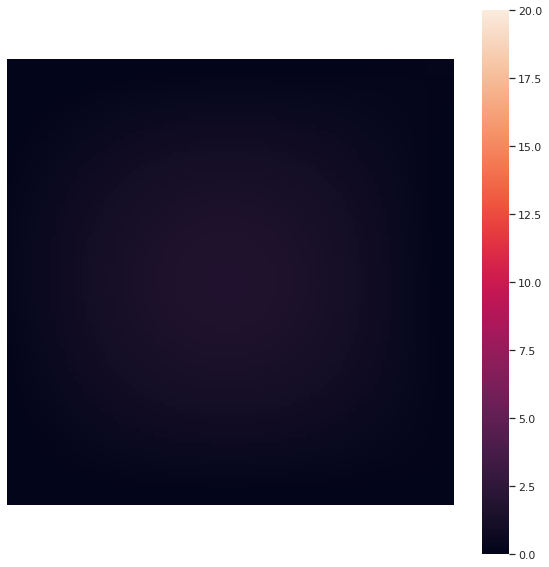

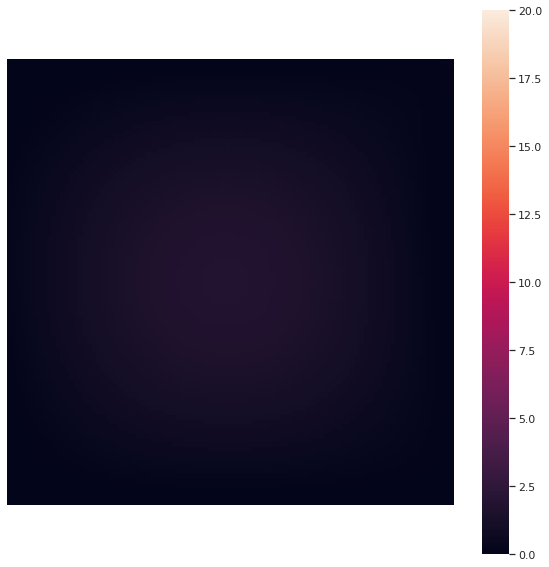

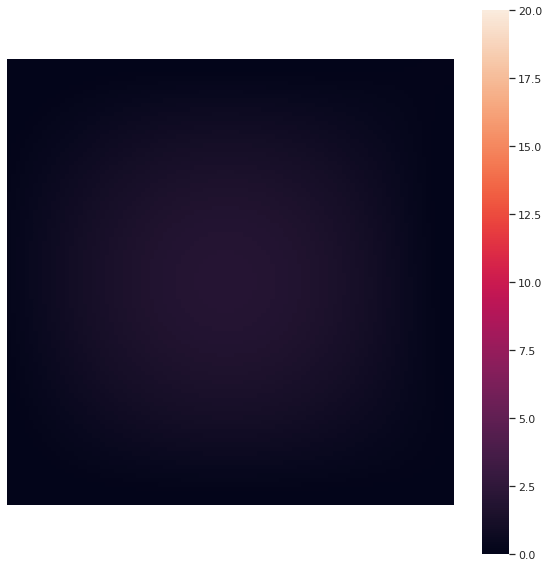

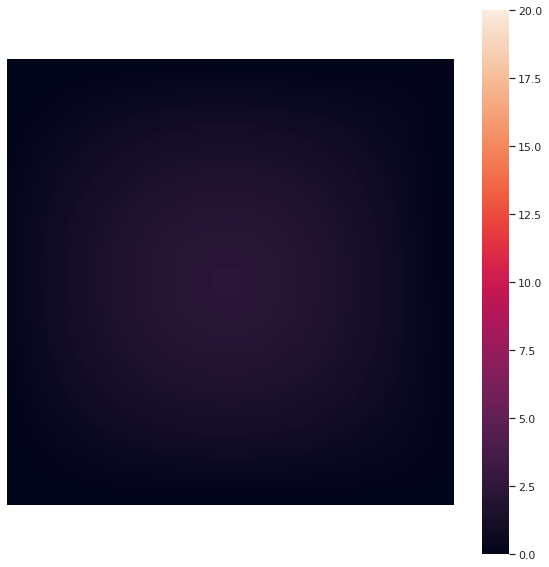

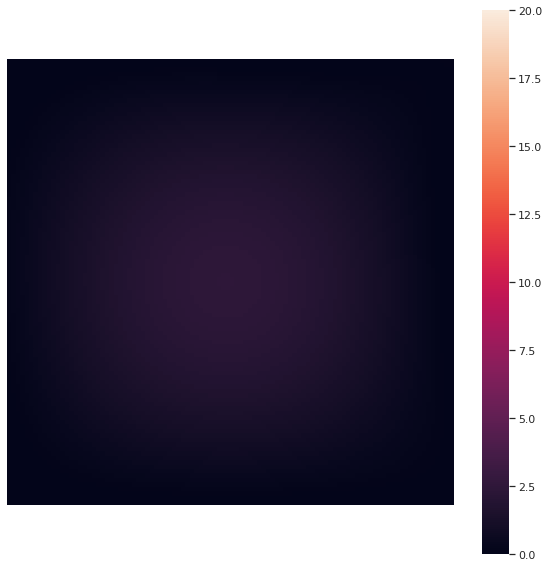

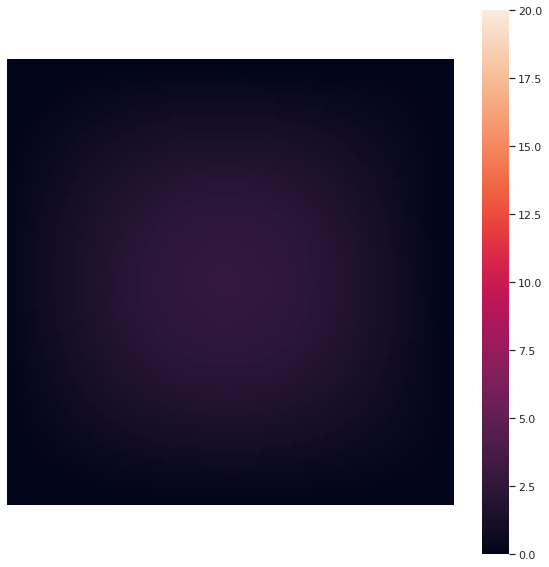

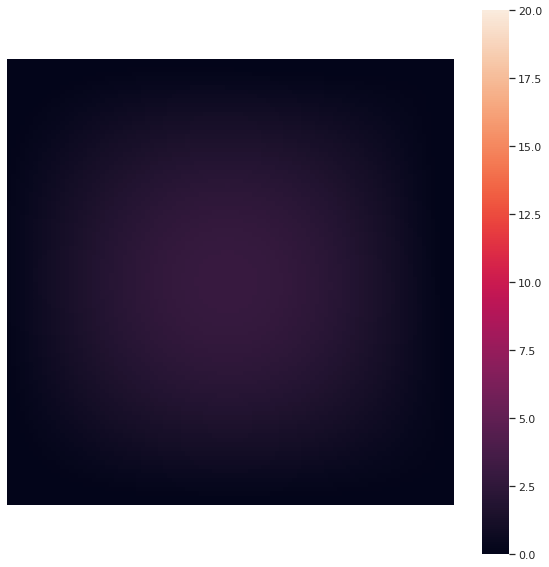

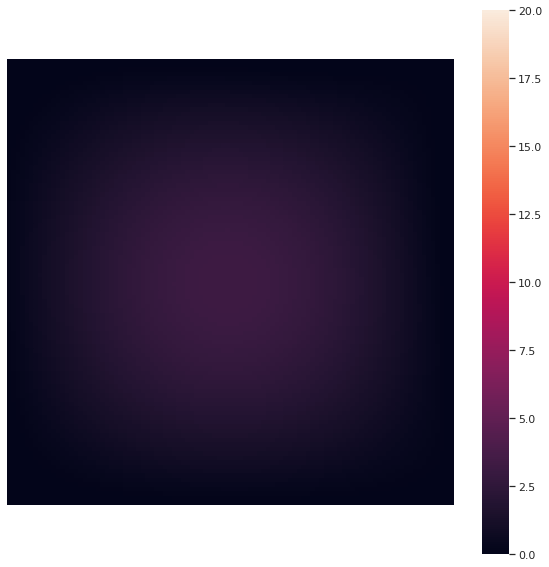

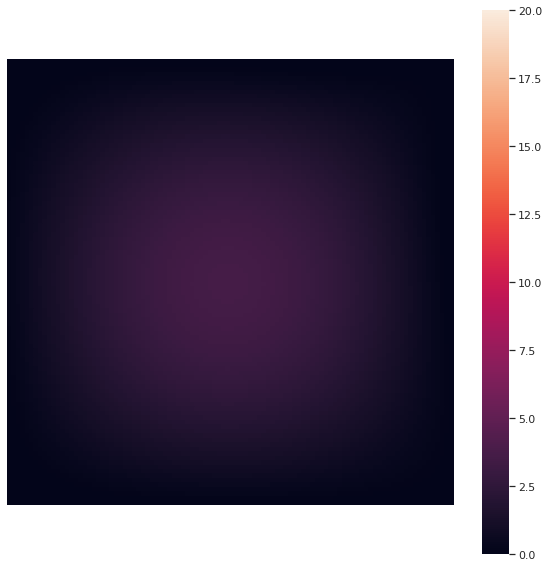

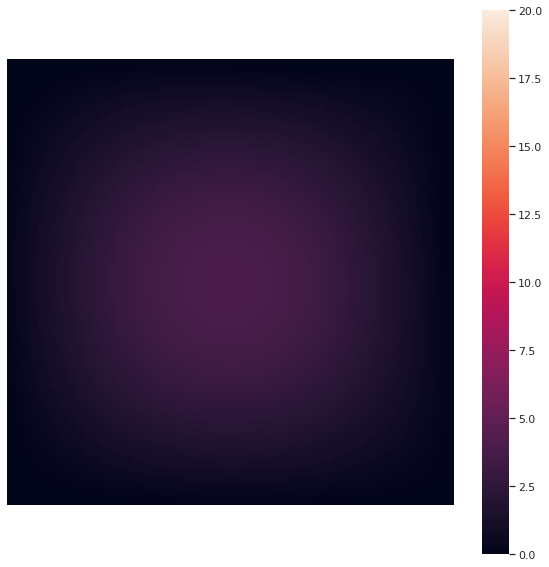

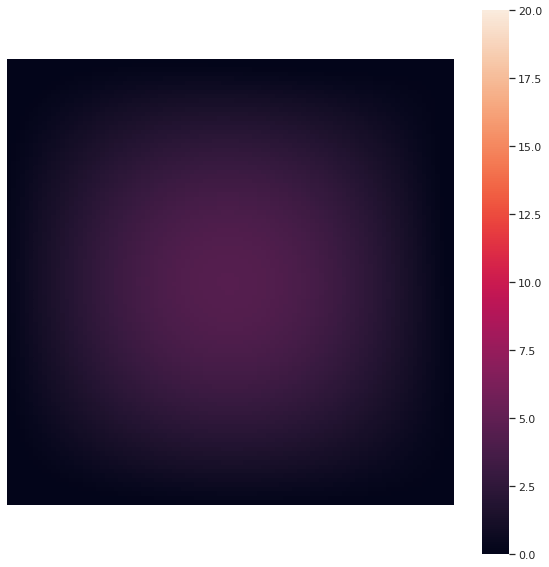

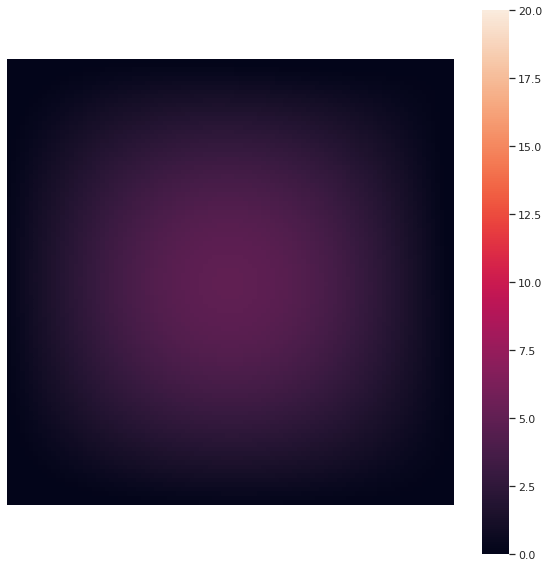

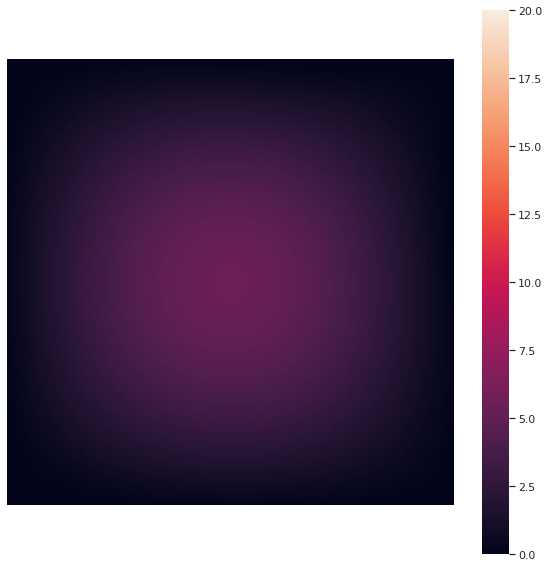

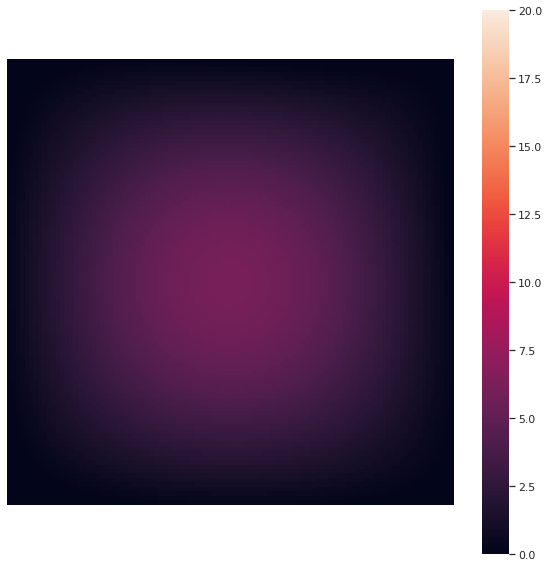

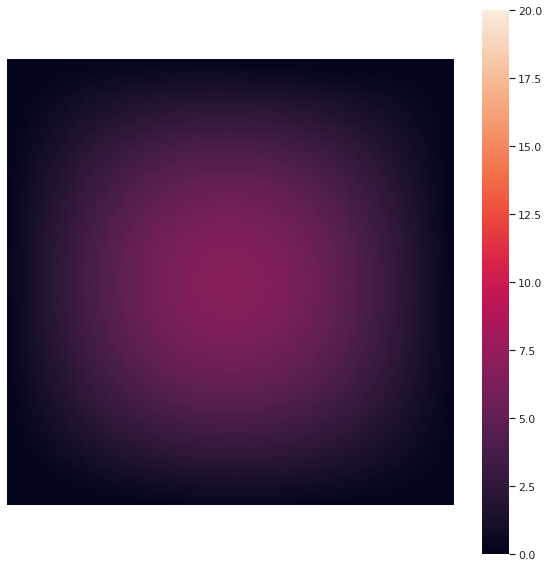

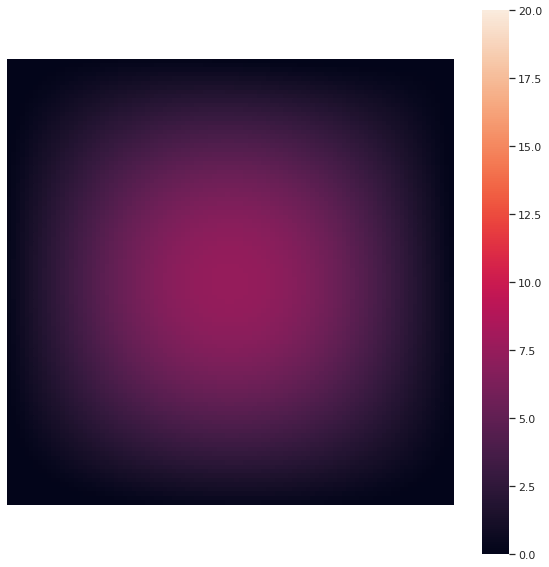

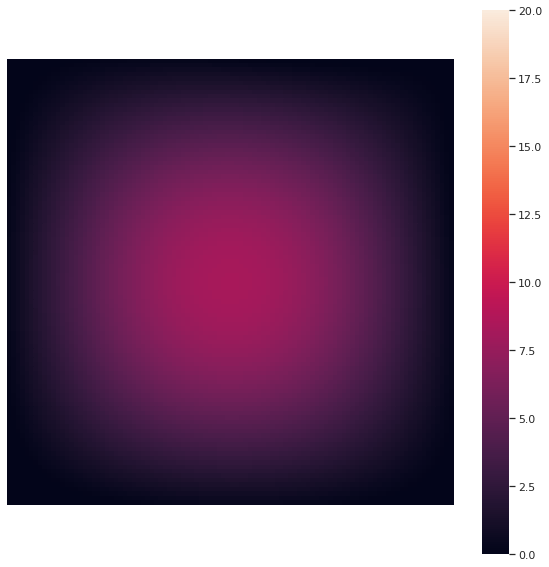

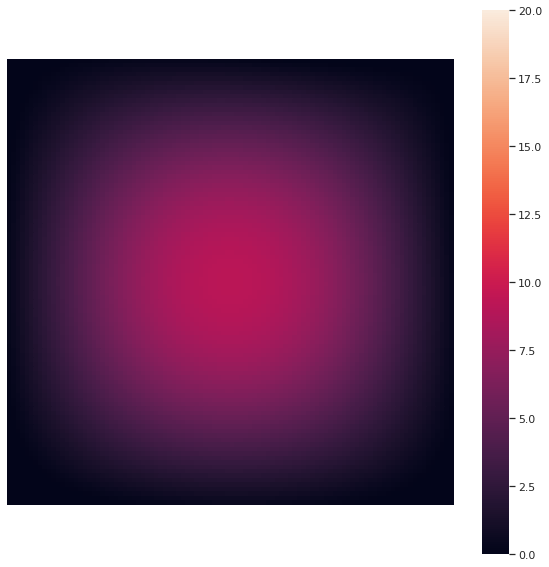

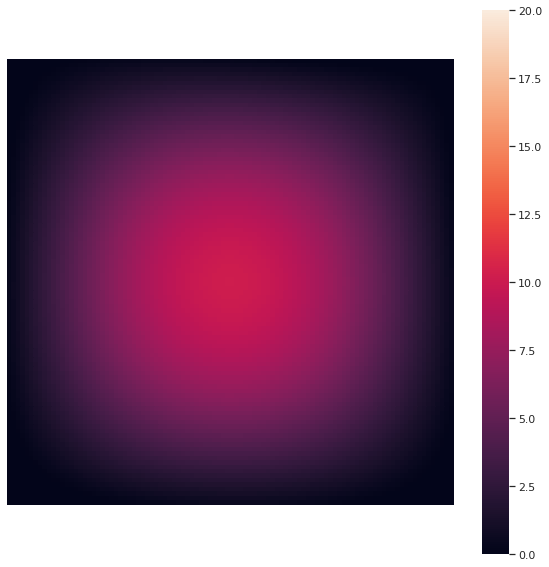

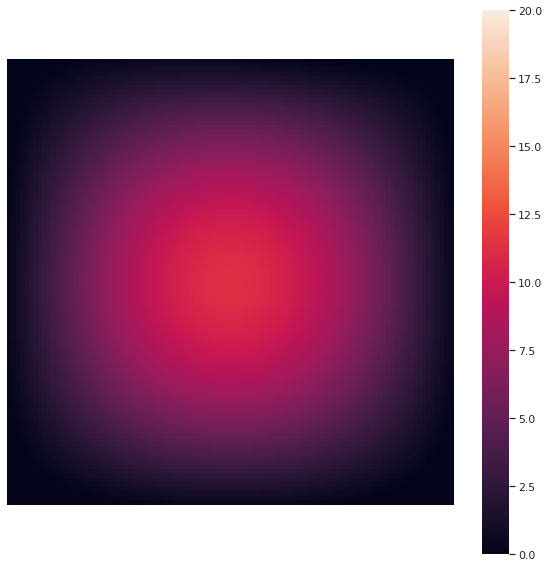

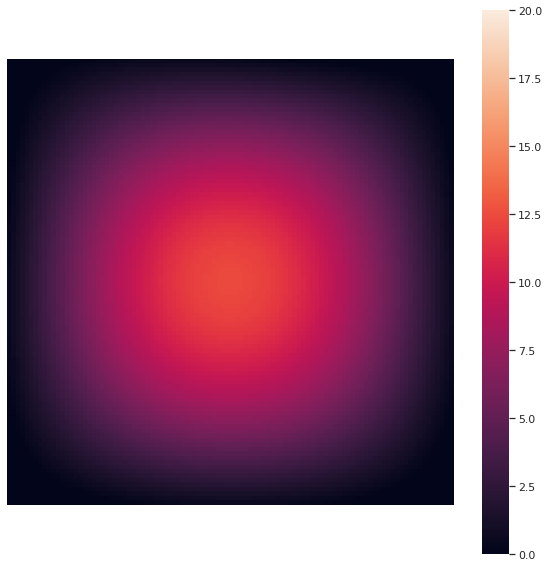

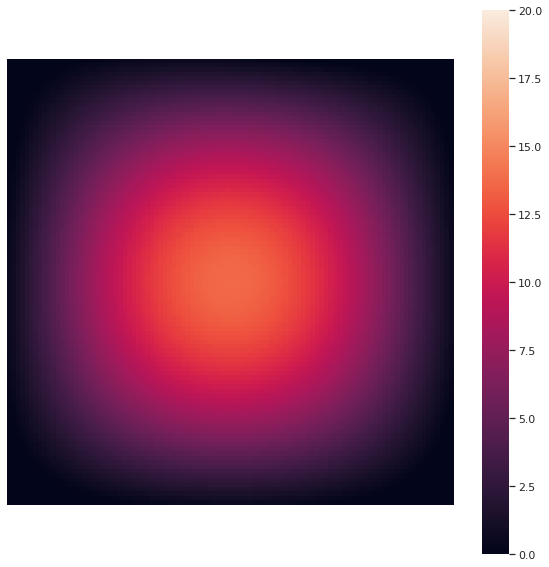

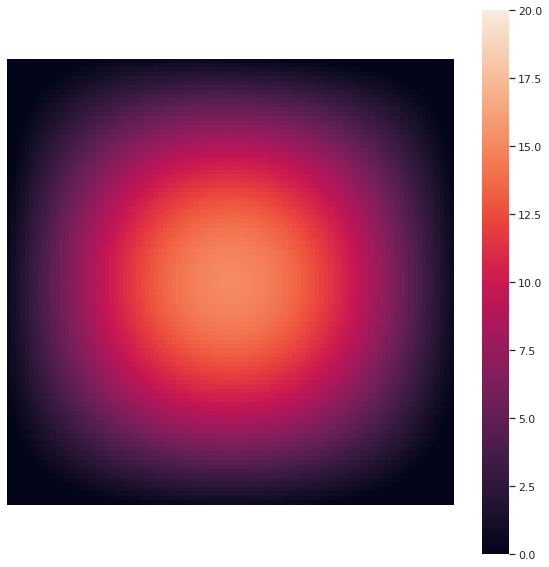

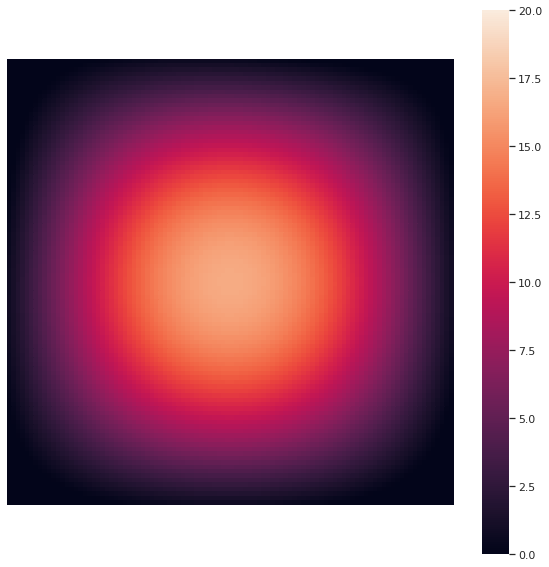

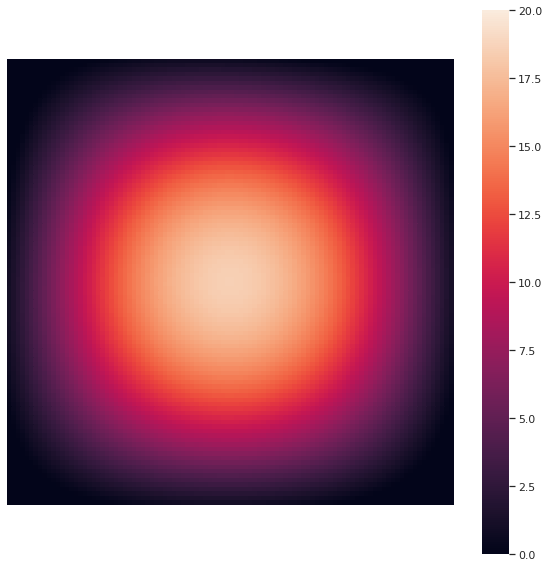

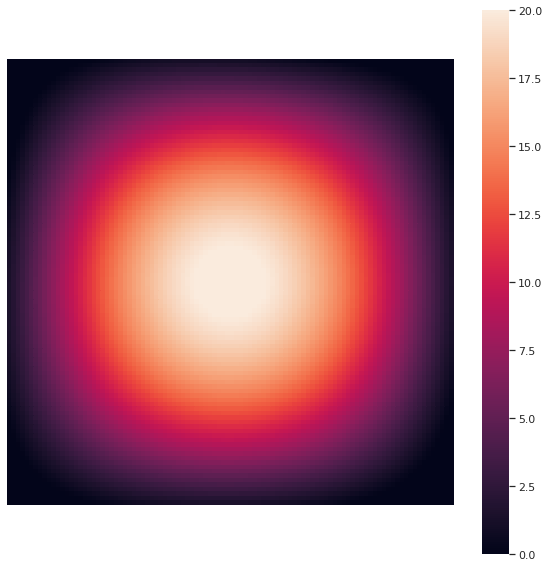

In [11]:
# CREATE IMAGES
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

u_xyt = np.zeros(shape=(n,n), dtype=float)

for k in range(31):
    for i in range(n):
        for j in range(n):
            u1 = u(model1, x[i], y[j], k*0.1)
            u_xyt[i,j] = u1
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(u_xyt, square = True, xticklabels = False, yticklabels = False, vmax = 20, vmin = 0)
    plt.savefig("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/images/" + str(k) + ".png")

In [12]:
# CREATE GIF
png_dir = '/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/images/'
images = []
for file_name in os.listdir(png_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(png_dir + 'movie.gif', images, fps = 10)